<h1>Capsnet: "Dynamic Routing Between Capsules"</h1>
<h4><span style="text-decoration: underline;">Original Paper:</span> Geoffrey E. Hinton,&nbsp;Sara Sabour,&nbsp; Nicholas Frosst</h4>
<h4><span style="text-decoration: underline;">Notebook Author:</span>&nbsp; Brandon Lwowski</h4>

<h2>I. Introduction</h2>
<p>Geoffrey Hinton and his colleagues developed a new architecture for neural nets called Capsule Networks in order to tackle some of the negatives and issues with the traditional CNN. The Convolutional Neural Network is commonly used in tasks such as computer vision and text classification. VGG-16, Inception, and ResNet-50 are all architectures that are extremely successful in the domain of computer vision and all use multiple convolutional layers in their networks.</p>
<p>Even with the large amount of success that CNN's have earned, there are drawbacks present that limit their overall ability. CNN's do not store spatial or orientational relationships between features. The most common example is the human face. As long as the image has 2 eyes, a nose, and a mouth, the CNN will classify it a face, regardless of if the mouth is above the eyes, or the nose is by the ears.&nbsp;</p>
<p>The Capsule Network was Hinton&rsquo;s attempt to fix these known issues of CNN's. The "capsules" in this architecture learn spatial and orientational features, which will be discussed later in this notebook. In this notebook you will see my implementation of a Capsule Network on the MNIST data set. The network is trained on data that has not been augmented and tested on images that have been scaled and rotated. You will see that the CapsNet does well on the scaled data but, still struggles to solve the rotational invariance issue with traditional CNNs.</p>
<img src = "./images/capsnet.png">
<h2>II. Background</h2>
<p>&nbsp;</p>
<p>What are Capsules? You can find a detailed explanation in Hinton&rsquo;s first paper "<a href="http://www.cs.toronto.edu/~fritz/absps/transauto6.pdf">Transforming Auto-encoders</a>" but I will do my best to paraphrase here. A capsule is a set of neurons that produce a vector. This differs from a typical neural network, where the output is a scalar. This vector can represent the size, orientation, or even the hue of the image once trained.</p>
<p>&nbsp;</p>
<img src = "./images/capsule.png">
<p>In the image above you will see 2 different types of capsules. The red capsules are created using 3 neurons and the green capsules are created using 4 neurons. The red capsules are used as recognition units and the green capsules are used as generation units (This will be discussed further down in the notebook).&nbsp; The recognition units, are similar to the hidden layer in a general artificial neural network, are used to compute the X-position, Y-position and the probability that the visual feature is present in the input image. The generation units receive the X-position plus the change in X and the Y-position plus the change in Y and then multiplied by the probability to generate the actual output. The distance between the actual output and target output are then calculated and used to adjust the capsules weights. By multiplying the output of the generation units by the probability, inactive capsules will not affect the actual output.</p>

<h2>III. Implementation</h2>
<p>Below you will find my pytorch implementation of capsule networks and the dynamic routing algorithm provided by Hinton.&nbsp;</p>

In [28]:
### Import Libraries

### pytorch libraries needed
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np               ### Matrix Math
import matplotlib.pyplot as plt  ### Data visualizations

from tqdm import tqdm            ### Create progress bar
import gc                        ### Garbage collect to save memory

In [29]:
### Hyperparameters
USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 12
N_EPOCHS = 30            
LEARNING_RATE = 0.0001
MOMENTUM = 0.7

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [30]:
gc.collect()

66

<h2>III(a). Data and Data Analysis</h2>
<p>The following four functions are used to create train and test data. For this experiment of the capsule network, I plan to train the model on data that has not been augmented. It will be trained on the original 29x29 MNIST data set. The goal of this notebook is to investigate how well the model can classify MNIST data that has been rotated or scaled. The test_loader is a base line; these images are not augmented. test_loader _rotate is a test set of MNIST images randomly rotated -75 degrees to 75 degrees. Lastly, the test_loader_scale_half was resized, so the image is half the size and padded to match the 28x28 dimensions. Below those 4 functions you will find examples of training set, test set original, test set rotated, and test set scaled&nbsp;</p>
<img src = "./images/MNIST.png">


In [31]:
### Get MNIST Data

#train = True pulls from training set train = False pulls from testing data
#Compose() chains multiple transformations together
#ToTensor() transforms PIL image or numpy array to torch tensor
#Normalize() normalize a tensor image with mean and standard deviation (mean, std)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader_rotate = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.RandomRotation((-75,75)),
                               torchvision.transforms.Resize((28, 28)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader_scale_half = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                transforms.Resize(20),
                                transforms.Pad(padding=4, padding_mode='edge'),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

Index: 0
Example Shape: torch.Size([128, 1, 28, 28])
Target Shape : torch.Size([128])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

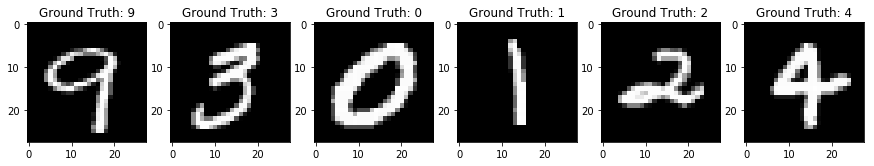

In [24]:
### Train Data
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

Index: 0
Example Shape: torch.Size([128, 1, 28, 28])
Target Shape : torch.Size([128])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

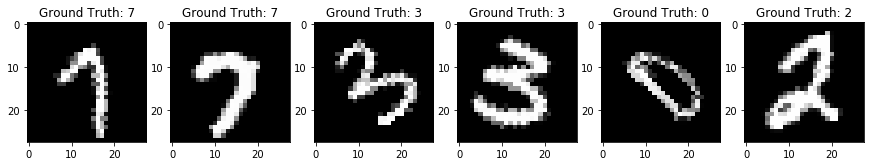

In [6]:
### Test Data Rotate
examples = enumerate(test_loader_rotate)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

Index: 0
Example Shape: torch.Size([128, 1, 28, 28])
Target Shape : torch.Size([128])


<module 'matplotlib.pyplot' from '/home/ubuntu/.local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

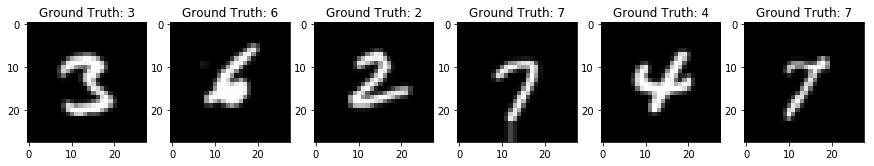

In [7]:
### Test Data Scale
examples = enumerate(test_loader_scale_half)
batch_idx, (example_data, example_targets) = next(examples)

print ("Index:", batch_idx)
print ("Example Shape:", example_data.shape)
print ("Target Shape :", example_targets.shape)

fig = plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(1,6, i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt

In [8]:
gc.collect()

20716

<h2>III(b). Design</h2>
<p>&nbsp;</p>



<p>&nbsp;</p>
<h4>Squash Function from CapsNet Paper <a href="https://arxiv.org/pdf/1710.09829.pdf">[source]</a></h4>
<p><img src="https://pechyonkin.me/images/201711-capsules-2/squash.png" width="428" height="142" /></p>

<p>&nbsp;</p>
<h4>Margin Loss from CapsNet Paper <a href="https://arxiv.org/pdf/1710.09829.pdf">[source]</a></h4>
<p><img src="https://pechyonkin.me/images/201802-capsules-4/2.png" width="800" height="400" /></p>

In [9]:
def squash(input_tensor):
    squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
    output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
    return output_tensor

def margin_loss(x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

# Layers Needed
### Layer 1 = Convolutional Layer
<p>Input = 28x28 image (one color channel)</p>
<p>Number of Kernals = 256</p>
<p>Kernal Size = 9x9</p>
<p>Stride = 1</p>
<p>Output = 20x20x256</p>

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=1
                              )

    def forward(self, x):
        return F.relu(self.conv(x))

### Layer 2 = Primary Caps Layer
<p>Input = 20x20x256 tensor</p>
<p> Number of Capsules = 32</p>
<p>Kernal Size = 9x9x256</p>
<p>Stride = 2</p>
<p>Output = 6x6x9x32 tensor</p>

In [11]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, num_routes=32 * 6 * 6):
        super(PrimaryCaps, self).__init__()
        self.num_routes = num_routes
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.num_routes, -1)
        return squash(u)

### Layer 3 = Digit Caps Layer
<p>Input = 6x6x8x32 tensor</p>
<p>Number of Capsules = 10 </p>

<p>Output = 16x10 matrix</p>


In [12]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij, dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)


### Decoder
<p>Input =&nbsp;16-dimensional vector from the Digit Capsule Layer</p>
<p>Output = 28x28 reconstructed image</p>
<p>Loss Function =&nbsp;&nbsp;Euclidean distance between the reconstructed image and the input image&nbsp;</p>

### Layer 4 = Fully Connected 1
<p>Input =&nbsp;16x10 flattened (160 nodes)</p>
<p>Output = 512 nodes</p>

### Layer 5 = Fully Connected 2
<p>Input 512 nodes</p>
<p>Output = 1024 nodes</p>

### Layer 6 = Fully Connected 3
<p>Input 1024 nodes</p>
<p>Output = 784 nodes (28x28)</p>

In [13]:
class Decoder(nn.Module):
    def __init__(self, input_width=28, input_height=28, input_channel=1):
        super(Decoder, self).__init__()
        self.input_width = input_width
        self.input_height = input_height
        self.input_channel = input_channel
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, self.input_height * self.input_height * self.input_channel),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes, dim=0)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        t = (x * masked[:, :, None, None]).view(x.size(0), -1)
        reconstructions = self.reconstraction_layers(t)
        reconstructions = reconstructions.view(-1, self.input_channel, self.input_width, self.input_height)
        return reconstructions, masked

In [14]:
gc.collect()

44

# Construct Entire Capsule Network Model

In [15]:
class CapsNet(nn.Module):
    def __init__(self, config=None):
        super(CapsNet, self).__init__()
        if config:
            self.conv_layer = ConvLayer(config.cnn_in_channels, config.cnn_out_channels, config.cnn_kernel_size)
            self.primary_capsules = PrimaryCaps(config.pc_num_capsules, config.pc_in_channels, config.pc_out_channels,
                                                config.pc_kernel_size, config.pc_num_routes)
            self.digit_capsules = DigitCaps(config.dc_num_capsules, config.dc_num_routes, config.dc_in_channels,
                                            config.dc_out_channels)
            self.decoder = Decoder(config.input_width, config.input_height, config.cnn_in_channels)
        else:
            self.conv_layer = ConvLayer()
            self.primary_capsules = PrimaryCaps()
            self.digit_capsules = DigitCaps()
            self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)


    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

# Train and Test Loops for the Model

In [16]:
def train(model, optimizer, train_loader, epoch):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        train_loss = loss.data
        total_loss += train_loss
        if batch_id % 100 == 0:
            tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                epoch,
                N_EPOCHS,
                batch_id + 1,
                n_batch,
                correct / float(BATCH_SIZE),
                train_loss / float(BATCH_SIZE)
                ))
    tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,N_EPOCHS,total_loss / len(train_loader.dataset)))
    
def test(capsule_net, test_loader, epoch, name):
    capsule_net.eval()
    test_loss = 0
    correct = 0
    for batch_id, (data, target) in enumerate(test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))

    tqdm.write(
        "Epoch: [{}/{}], test accuracy {}: {:.6f}, loss: {:.6f}".format(epoch, N_EPOCHS, str(name), correct / len(test_loader.dataset),
                                                                  test_loss / len(test_loader)))


# Run the Training

In [ ]:
gc.collect()
capsule_net = CapsNet()

if USE_CUDA:
    capsule_net = capsule_net.cuda()
#capsule_net = capsule_net.module

optimizer = torch.optim.Adam(capsule_net.parameters())

for e in range(1, N_EPOCHS + 1):
    train(capsule_net, optimizer, train_loader, e)
    test(capsule_net, test_loader, e, "NORMAL TEST")
    test(capsule_net, test_loader_rotate, e, "ROTATED TEST")
    test(capsule_net, test_loader_scale_half, e, "SCALE TEST")


torch.save(capsule_net.state_dict(), './capsnet_trained.model')



  0%|          | 1/469 [00:06<48:01,  6.16s/it]

Epoch: [1/30], Batch: [1/469], train accuracy: 0.148438, loss: 0.007026


 22%|██▏       | 101/469 [07:31<25:21,  4.13s/it]

Epoch: [1/30], Batch: [101/469], train accuracy: 0.914062, loss: 0.003303


 43%|████▎     | 201/469 [14:38<18:39,  4.18s/it]

Epoch: [1/30], Batch: [201/469], train accuracy: 0.960938, loss: 0.002137


 64%|██████▍   | 301/469 [21:50<11:35,  4.14s/it]

Epoch: [1/30], Batch: [301/469], train accuracy: 0.976562, loss: 0.000860


 86%|████████▌ | 401/469 [29:12<04:43,  4.17s/it]

Epoch: [1/30], Batch: [401/469], train accuracy: 0.953125, loss: 0.000870


100%|██████████| 469/469 [34:12<00:00,  4.09s/it]


Epoch: [1/30], train loss: 0.002153
Epoch: [1/30], test accuracy NORMAL TEST: 0.979450, loss: 0.065677
Epoch: [1/30], test accuracy ROTATED TEST: 0.627300, loss: 0.511733
Epoch: [1/30], test accuracy SCALE TEST: 0.902800, loss: 0.353877


  0%|          | 1/469 [00:04<34:39,  4.44s/it]

Epoch: [2/30], Batch: [1/469], train accuracy: 0.945312, loss: 0.000627


 22%|██▏       | 101/469 [07:08<27:32,  4.49s/it]

Epoch: [2/30], Batch: [101/469], train accuracy: 0.992188, loss: 0.000425


 43%|████▎     | 201/469 [13:58<18:04,  4.05s/it]

Epoch: [2/30], Batch: [201/469], train accuracy: 0.976562, loss: 0.000369


 64%|██████▍   | 301/469 [20:52<11:38,  4.16s/it]

Epoch: [2/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000352


 86%|████████▌ | 401/469 [28:17<04:55,  4.34s/it]

Epoch: [2/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000208


100%|██████████| 469/469 [33:16<00:00,  4.12s/it]


Epoch: [2/30], train loss: 0.000407
Epoch: [2/30], test accuracy NORMAL TEST: 0.987183, loss: 0.039539
Epoch: [2/30], test accuracy ROTATED TEST: 0.631700, loss: 0.510960
Epoch: [2/30], test accuracy SCALE TEST: 0.923500, loss: 0.339865


  0%|          | 1/469 [00:04<35:40,  4.57s/it]

Epoch: [3/30], Batch: [1/469], train accuracy: 0.976562, loss: 0.000437


 22%|██▏       | 101/469 [07:32<27:10,  4.43s/it]

Epoch: [3/30], Batch: [101/469], train accuracy: 0.992188, loss: 0.000255


 43%|████▎     | 201/469 [14:55<20:06,  4.50s/it]

Epoch: [3/30], Batch: [201/469], train accuracy: 0.984375, loss: 0.000307


 64%|██████▍   | 301/469 [22:31<12:52,  4.60s/it]

Epoch: [3/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000193


 86%|████████▌ | 401/469 [30:15<05:22,  4.74s/it]

Epoch: [3/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000241


100%|██████████| 469/469 [35:29<00:00,  4.19s/it]


Epoch: [3/30], train loss: 0.000282
Epoch: [3/30], test accuracy NORMAL TEST: 0.990517, loss: 0.028983
Epoch: [3/30], test accuracy ROTATED TEST: 0.649400, loss: 0.489175
Epoch: [3/30], test accuracy SCALE TEST: 0.946800, loss: 0.237094


  0%|          | 1/469 [00:05<40:20,  5.17s/it]

Epoch: [4/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000259


 22%|██▏       | 101/469 [07:30<24:33,  4.00s/it]

Epoch: [4/30], Batch: [101/469], train accuracy: 0.984375, loss: 0.000328


 43%|████▎     | 201/469 [14:10<17:49,  3.99s/it]

Epoch: [4/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000244


 64%|██████▍   | 301/469 [21:15<12:32,  4.48s/it]

Epoch: [4/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000133


 86%|████████▌ | 401/469 [28:24<04:50,  4.28s/it]

Epoch: [4/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000104


100%|██████████| 469/469 [33:03<00:00,  3.81s/it]


Epoch: [4/30], train loss: 0.000229
Epoch: [4/30], test accuracy NORMAL TEST: 0.992750, loss: 0.024353
Epoch: [4/30], test accuracy ROTATED TEST: 0.638800, loss: 0.489117
Epoch: [4/30], test accuracy SCALE TEST: 0.947100, loss: 0.285531


  0%|          | 1/469 [00:04<31:22,  4.02s/it]

Epoch: [5/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000099


 22%|██▏       | 101/469 [06:59<25:43,  4.19s/it]

Epoch: [5/30], Batch: [101/469], train accuracy: 0.984375, loss: 0.000234


 43%|████▎     | 201/469 [14:30<20:35,  4.61s/it]

Epoch: [5/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000126


 64%|██████▍   | 301/469 [22:13<12:53,  4.60s/it]

Epoch: [5/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000224


 86%|████████▌ | 401/469 [29:59<05:15,  4.64s/it]

Epoch: [5/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000177


100%|██████████| 469/469 [35:15<00:00,  4.42s/it]


Epoch: [5/30], train loss: 0.000196
Epoch: [5/30], test accuracy NORMAL TEST: 0.993750, loss: 0.021016
Epoch: [5/30], test accuracy ROTATED TEST: 0.655200, loss: 0.479202
Epoch: [5/30], test accuracy SCALE TEST: 0.957100, loss: 0.253193


  0%|          | 1/469 [00:04<37:48,  4.85s/it]

Epoch: [6/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000139


 22%|██▏       | 101/469 [07:51<27:37,  4.50s/it]

Epoch: [6/30], Batch: [101/469], train accuracy: 0.992188, loss: 0.000098


 43%|████▎     | 201/469 [15:42<20:20,  4.55s/it]

Epoch: [6/30], Batch: [201/469], train accuracy: 0.992188, loss: 0.000144


 64%|██████▍   | 301/469 [23:27<13:02,  4.66s/it]

Epoch: [6/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000110


 86%|████████▌ | 401/469 [31:12<05:15,  4.64s/it]

Epoch: [6/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000128


100%|██████████| 469/469 [36:28<00:00,  4.38s/it]


Epoch: [6/30], train loss: 0.000171
Epoch: [6/30], test accuracy NORMAL TEST: 0.994200, loss: 0.018071
Epoch: [6/30], test accuracy ROTATED TEST: 0.656700, loss: 0.481726
Epoch: [6/30], test accuracy SCALE TEST: 0.958000, loss: 0.228091


  0%|          | 1/469 [00:05<44:48,  5.74s/it]

Epoch: [7/30], Batch: [1/469], train accuracy: 0.984375, loss: 0.000182


 22%|██▏       | 101/469 [07:50<28:30,  4.65s/it]

Epoch: [7/30], Batch: [101/469], train accuracy: 0.992188, loss: 0.000131


 43%|████▎     | 201/469 [15:28<19:43,  4.42s/it]

Epoch: [7/30], Batch: [201/469], train accuracy: 0.984375, loss: 0.000178


 64%|██████▍   | 301/469 [22:26<12:02,  4.30s/it]

Epoch: [7/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000129


 86%|████████▌ | 401/469 [29:29<04:51,  4.29s/it]

Epoch: [7/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000102


100%|██████████| 469/469 [34:33<00:00,  4.29s/it]


Epoch: [7/30], train loss: 0.000151
Epoch: [7/30], test accuracy NORMAL TEST: 0.995233, loss: 0.016198
Epoch: [7/30], test accuracy ROTATED TEST: 0.662500, loss: 0.465714
Epoch: [7/30], test accuracy SCALE TEST: 0.960700, loss: 0.243780


  0%|          | 1/469 [00:05<43:48,  5.62s/it]

Epoch: [8/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000080


 22%|██▏       | 101/469 [07:37<26:52,  4.38s/it]

Epoch: [8/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000070


 43%|████▎     | 201/469 [15:15<20:58,  4.69s/it]

Epoch: [8/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000039


 64%|██████▍   | 301/469 [23:03<12:48,  4.57s/it]

Epoch: [8/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000081


 86%|████████▌ | 401/469 [30:47<05:26,  4.80s/it]

Epoch: [8/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000190


100%|██████████| 469/469 [36:01<00:00,  4.25s/it]


Epoch: [8/30], train loss: 0.000135
Epoch: [8/30], test accuracy NORMAL TEST: 0.995550, loss: 0.016238
Epoch: [8/30], test accuracy ROTATED TEST: 0.659100, loss: 0.478317
Epoch: [8/30], test accuracy SCALE TEST: 0.960000, loss: 0.219257


  0%|          | 1/469 [00:05<44:18,  5.68s/it]

Epoch: [9/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000223


 22%|██▏       | 101/469 [07:39<26:28,  4.32s/it]

Epoch: [9/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000106


 43%|████▎     | 201/469 [14:37<19:43,  4.42s/it]

Epoch: [9/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000075


 64%|██████▍   | 301/469 [21:48<12:56,  4.62s/it]

Epoch: [9/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000176


 86%|████████▌ | 401/469 [29:24<04:58,  4.39s/it]

Epoch: [9/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000159


100%|██████████| 469/469 [34:18<00:00,  3.99s/it]


Epoch: [9/30], train loss: 0.000122
Epoch: [9/30], test accuracy NORMAL TEST: 0.996717, loss: 0.012751
Epoch: [9/30], test accuracy ROTATED TEST: 0.677000, loss: 0.450946
Epoch: [9/30], test accuracy SCALE TEST: 0.965100, loss: 0.197020


  0%|          | 1/469 [00:04<35:58,  4.61s/it]

Epoch: [10/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000089


 22%|██▏       | 101/469 [07:25<29:14,  4.77s/it]

Epoch: [10/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000049


 43%|████▎     | 201/469 [15:09<20:55,  4.69s/it]

Epoch: [10/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000061


 64%|██████▍   | 301/469 [22:47<12:46,  4.56s/it]

Epoch: [10/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000155


 86%|████████▌ | 401/469 [30:36<05:23,  4.76s/it]

Epoch: [10/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000235


100%|██████████| 469/469 [35:50<00:00,  4.31s/it]


Epoch: [10/30], train loss: 0.000110
Epoch: [10/30], test accuracy NORMAL TEST: 0.996350, loss: 0.016938
Epoch: [10/30], test accuracy ROTATED TEST: 0.662000, loss: 0.496542
Epoch: [10/30], test accuracy SCALE TEST: 0.961700, loss: 0.230550


  0%|          | 1/469 [00:04<36:13,  4.64s/it]

Epoch: [11/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000125


 22%|██▏       | 101/469 [07:51<29:40,  4.84s/it]

Epoch: [11/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000063


 43%|████▎     | 201/469 [15:39<20:38,  4.62s/it]

Epoch: [11/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000027


 64%|██████▍   | 301/469 [23:23<12:49,  4.58s/it]

Epoch: [11/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000070


 86%|████████▌ | 401/469 [31:09<05:08,  4.54s/it]

Epoch: [11/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000114


100%|██████████| 469/469 [36:18<00:00,  4.24s/it]


Epoch: [11/30], train loss: 0.000099
Epoch: [11/30], test accuracy NORMAL TEST: 0.997700, loss: 0.009959
Epoch: [11/30], test accuracy ROTATED TEST: 0.667600, loss: 0.456128
Epoch: [11/30], test accuracy SCALE TEST: 0.967300, loss: 0.216277


  0%|          | 1/469 [00:05<40:14,  5.16s/it]

Epoch: [12/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000154


 22%|██▏       | 101/469 [07:57<28:53,  4.71s/it]

Epoch: [12/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000021


 43%|████▎     | 201/469 [15:45<21:21,  4.78s/it]

Epoch: [12/30], Batch: [201/469], train accuracy: 0.992188, loss: 0.000090


 64%|██████▍   | 301/469 [23:26<12:56,  4.62s/it]

Epoch: [12/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000078


 86%|████████▌ | 401/469 [31:08<05:09,  4.56s/it]

Epoch: [12/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000191


100%|██████████| 469/469 [36:09<00:00,  4.15s/it]


Epoch: [12/30], train loss: 0.000092
Epoch: [12/30], test accuracy NORMAL TEST: 0.997917, loss: 0.009049
Epoch: [12/30], test accuracy ROTATED TEST: 0.667900, loss: 0.466848
Epoch: [12/30], test accuracy SCALE TEST: 0.964800, loss: 0.196202


  0%|          | 1/469 [00:04<37:00,  4.74s/it]

Epoch: [13/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000028


 22%|██▏       | 101/469 [07:09<26:42,  4.35s/it]

Epoch: [13/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000054


 43%|████▎     | 201/469 [14:20<18:48,  4.21s/it]

Epoch: [13/30], Batch: [201/469], train accuracy: 0.992188, loss: 0.000129


 64%|██████▍   | 301/469 [21:17<12:03,  4.31s/it]

Epoch: [13/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000114


 86%|████████▌ | 401/469 [28:12<04:44,  4.18s/it]

Epoch: [13/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000049


100%|██████████| 469/469 [32:51<00:00,  3.86s/it]


Epoch: [13/30], train loss: 0.000080
Epoch: [13/30], test accuracy NORMAL TEST: 0.998033, loss: 0.008483
Epoch: [13/30], test accuracy ROTATED TEST: 0.668300, loss: 0.466907
Epoch: [13/30], test accuracy SCALE TEST: 0.970200, loss: 0.171717


  0%|          | 1/469 [00:04<37:01,  4.75s/it]

Epoch: [14/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000035


 22%|██▏       | 101/469 [07:06<25:17,  4.12s/it]

Epoch: [14/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000033


 43%|████▎     | 201/469 [13:58<19:23,  4.34s/it]

Epoch: [14/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000058


 64%|██████▍   | 301/469 [21:05<11:56,  4.27s/it]

Epoch: [14/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000086


 86%|████████▌ | 401/469 [28:19<05:04,  4.48s/it]

Epoch: [14/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000091


100%|██████████| 469/469 [33:27<00:00,  4.31s/it]


Epoch: [14/30], train loss: 0.000069
Epoch: [14/30], test accuracy NORMAL TEST: 0.998500, loss: 0.008244
Epoch: [14/30], test accuracy ROTATED TEST: 0.674000, loss: 0.449251
Epoch: [14/30], test accuracy SCALE TEST: 0.970100, loss: 0.199840


  0%|          | 1/469 [00:05<41:56,  5.38s/it]

Epoch: [15/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000132


 22%|██▏       | 101/469 [07:40<27:22,  4.46s/it]

Epoch: [15/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000025


 43%|████▎     | 201/469 [15:11<19:54,  4.46s/it]

Epoch: [15/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000045


 64%|██████▍   | 301/469 [22:59<13:09,  4.70s/it]

Epoch: [15/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000168


 86%|████████▌ | 401/469 [30:47<05:08,  4.54s/it]

Epoch: [15/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000044


100%|██████████| 469/469 [35:59<00:00,  4.35s/it]


Epoch: [15/30], train loss: 0.000065
Epoch: [15/30], test accuracy NORMAL TEST: 0.998600, loss: 0.007110
Epoch: [15/30], test accuracy ROTATED TEST: 0.664700, loss: 0.485770
Epoch: [15/30], test accuracy SCALE TEST: 0.966800, loss: 0.238797


  0%|          | 1/469 [00:04<38:42,  4.96s/it]

Epoch: [16/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000035


 22%|██▏       | 101/469 [06:43<24:09,  3.94s/it]

Epoch: [16/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000059


 43%|████▎     | 201/469 [13:55<19:27,  4.36s/it]

Epoch: [16/30], Batch: [201/469], train accuracy: 0.992188, loss: 0.000088


 64%|██████▍   | 301/469 [21:26<12:54,  4.61s/it]

Epoch: [16/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000023


 86%|████████▌ | 401/469 [29:04<05:15,  4.64s/it]

Epoch: [16/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000138


100%|██████████| 469/469 [34:18<00:00,  4.22s/it]


Epoch: [16/30], train loss: 0.000061
Epoch: [16/30], test accuracy NORMAL TEST: 0.998883, loss: 0.007015
Epoch: [16/30], test accuracy ROTATED TEST: 0.663500, loss: 0.468866
Epoch: [16/30], test accuracy SCALE TEST: 0.949700, loss: 0.270654


  0%|          | 1/469 [00:04<35:59,  4.61s/it]

Epoch: [17/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000099


 22%|██▏       | 101/469 [07:49<27:42,  4.52s/it]

Epoch: [17/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000083


 43%|████▎     | 201/469 [15:30<19:58,  4.47s/it]

Epoch: [17/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000044


 64%|██████▍   | 301/469 [23:11<12:58,  4.63s/it]

Epoch: [17/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000060


 86%|████████▌ | 401/469 [30:55<05:12,  4.59s/it]

Epoch: [17/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000065


100%|██████████| 469/469 [36:13<00:00,  4.29s/it]


Epoch: [17/30], train loss: 0.000055
Epoch: [17/30], test accuracy NORMAL TEST: 0.999033, loss: 0.005125
Epoch: [17/30], test accuracy ROTATED TEST: 0.655800, loss: 0.476999
Epoch: [17/30], test accuracy SCALE TEST: 0.973700, loss: 0.159088


  0%|          | 1/469 [00:05<44:38,  5.72s/it]

Epoch: [18/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000053


 22%|██▏       | 101/469 [07:45<28:52,  4.71s/it]

Epoch: [18/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000045


 43%|████▎     | 201/469 [14:54<18:06,  4.05s/it]

Epoch: [18/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000007


 64%|██████▍   | 301/469 [21:56<12:26,  4.44s/it]

Epoch: [18/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000033


 86%|████████▌ | 401/469 [29:01<04:51,  4.29s/it]

Epoch: [18/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000057


100%|██████████| 469/469 [34:03<00:00,  4.22s/it]


Epoch: [18/30], train loss: 0.000049
Epoch: [18/30], test accuracy NORMAL TEST: 0.999183, loss: 0.005370
Epoch: [18/30], test accuracy ROTATED TEST: 0.671900, loss: 0.453797
Epoch: [18/30], test accuracy SCALE TEST: 0.972600, loss: 0.165719


  0%|          | 1/469 [00:04<36:50,  4.72s/it]

Epoch: [19/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000115


 22%|██▏       | 101/469 [07:51<28:57,  4.72s/it]

Epoch: [19/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000072


 43%|████▎     | 201/469 [14:55<18:02,  4.04s/it]

Epoch: [19/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000060


 64%|██████▍   | 301/469 [22:08<12:45,  4.56s/it]

Epoch: [19/30], Batch: [301/469], train accuracy: 0.992188, loss: 0.000080


 86%|████████▌ | 401/469 [29:51<05:14,  4.62s/it]

Epoch: [19/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000035


100%|██████████| 469/469 [35:02<00:00,  4.33s/it]


Epoch: [19/30], train loss: 0.000043
Epoch: [19/30], test accuracy NORMAL TEST: 0.999300, loss: 0.004504
Epoch: [19/30], test accuracy ROTATED TEST: 0.656800, loss: 0.481089
Epoch: [19/30], test accuracy SCALE TEST: 0.973600, loss: 0.174761


  0%|          | 1/469 [00:05<42:55,  5.50s/it]

Epoch: [20/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000052


 22%|██▏       | 101/469 [07:49<28:46,  4.69s/it]

Epoch: [20/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000022


 43%|████▎     | 201/469 [15:30<20:36,  4.61s/it]

Epoch: [20/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000112


 64%|██████▍   | 301/469 [23:19<12:57,  4.63s/it]

Epoch: [20/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000053


 86%|████████▌ | 401/469 [31:08<05:13,  4.61s/it]

Epoch: [20/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000021


100%|██████████| 469/469 [36:25<00:00,  4.37s/it]


Epoch: [20/30], train loss: 0.000041
Epoch: [20/30], test accuracy NORMAL TEST: 0.999350, loss: 0.004771
Epoch: [20/30], test accuracy ROTATED TEST: 0.664700, loss: 0.464220
Epoch: [20/30], test accuracy SCALE TEST: 0.967500, loss: 0.240374


  0%|          | 1/469 [00:05<43:22,  5.56s/it]

Epoch: [21/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000019


 22%|██▏       | 101/469 [07:48<27:57,  4.56s/it]

Epoch: [21/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000014


 43%|████▎     | 201/469 [15:25<20:26,  4.58s/it]

Epoch: [21/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000048


 64%|██████▍   | 301/469 [23:07<12:57,  4.63s/it]

Epoch: [21/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000027


 86%|████████▌ | 401/469 [30:32<05:12,  4.60s/it]

Epoch: [21/30], Batch: [401/469], train accuracy: 0.992188, loss: 0.000064


100%|██████████| 469/469 [35:42<00:00,  4.34s/it]


Epoch: [21/30], train loss: 0.000042
Epoch: [21/30], test accuracy NORMAL TEST: 0.999417, loss: 0.005752
Epoch: [21/30], test accuracy ROTATED TEST: 0.677000, loss: 0.451573
Epoch: [21/30], test accuracy SCALE TEST: 0.955500, loss: 0.273643


  0%|          | 1/469 [00:04<37:56,  4.86s/it]

Epoch: [22/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000049


 22%|██▏       | 101/469 [07:40<28:19,  4.62s/it]

Epoch: [22/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000029


 43%|████▎     | 201/469 [14:50<19:16,  4.32s/it]

Epoch: [22/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000023


 64%|██████▍   | 301/469 [21:43<11:31,  4.12s/it]

Epoch: [22/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000056


 86%|████████▌ | 401/469 [28:29<04:33,  4.02s/it]

Epoch: [22/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000006


100%|██████████| 469/469 [33:02<00:00,  3.79s/it]


Epoch: [22/30], train loss: 0.000036
Epoch: [22/30], test accuracy NORMAL TEST: 0.999500, loss: 0.003557
Epoch: [22/30], test accuracy ROTATED TEST: 0.680600, loss: 0.443623
Epoch: [22/30], test accuracy SCALE TEST: 0.968700, loss: 0.194140


  0%|          | 1/469 [00:04<33:43,  4.32s/it]

Epoch: [23/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000019


 22%|██▏       | 101/469 [07:06<25:11,  4.11s/it]

Epoch: [23/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000027


 43%|████▎     | 201/469 [14:12<19:08,  4.29s/it]

Epoch: [23/30], Batch: [201/469], train accuracy: 1.000000, loss: 0.000028


 64%|██████▍   | 301/469 [21:15<11:26,  4.09s/it]

Epoch: [23/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000034


 86%|████████▌ | 401/469 [28:02<04:36,  4.07s/it]

Epoch: [23/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000053


100%|██████████| 469/469 [32:35<00:00,  3.69s/it]


Epoch: [23/30], train loss: 0.000033
Epoch: [23/30], test accuracy NORMAL TEST: 0.999533, loss: 0.003123
Epoch: [23/30], test accuracy ROTATED TEST: 0.663900, loss: 0.479767
Epoch: [23/30], test accuracy SCALE TEST: 0.974500, loss: 0.166412


  0%|          | 1/469 [00:05<40:29,  5.19s/it]

Epoch: [24/30], Batch: [1/469], train accuracy: 0.992188, loss: 0.000075


 22%|██▏       | 101/469 [07:34<28:18,  4.62s/it]

Epoch: [24/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000034


 43%|████▎     | 201/469 [15:06<20:09,  4.51s/it]

Epoch: [24/30], Batch: [201/469], train accuracy: 0.992188, loss: 0.000069


 64%|██████▍   | 301/469 [22:39<12:31,  4.47s/it]

Epoch: [24/30], Batch: [301/469], train accuracy: 1.000000, loss: 0.000023


 86%|████████▌ | 401/469 [30:17<05:14,  4.63s/it]

Epoch: [24/30], Batch: [401/469], train accuracy: 1.000000, loss: 0.000016


100%|██████████| 469/469 [35:26<00:00,  3.98s/it]


Epoch: [24/30], train loss: 0.000028
Epoch: [24/30], test accuracy NORMAL TEST: 0.999683, loss: 0.002898
Epoch: [24/30], test accuracy ROTATED TEST: 0.668800, loss: 0.460404
Epoch: [24/30], test accuracy SCALE TEST: 0.967400, loss: 0.210987


  0%|          | 1/469 [00:04<34:32,  4.43s/it]

Epoch: [25/30], Batch: [1/469], train accuracy: 1.000000, loss: 0.000023


 22%|██▏       | 101/469 [07:10<25:52,  4.22s/it]

Epoch: [25/30], Batch: [101/469], train accuracy: 1.000000, loss: 0.000034


 43%|████▎     | 201/469 [14:14<19:08,  4.28s/it]

Epoch: [25/30], Batch: [201/469], train accuracy: 0.101562, loss: nan


 64%|██████▍   | 301/469 [21:35<12:32,  4.48s/it]

Epoch: [25/30], Batch: [301/469], train accuracy: 0.085938, loss: nan


 86%|████████▌ | 401/469 [29:12<05:04,  4.48s/it]

Epoch: [25/30], Batch: [401/469], train accuracy: 0.031250, loss: nan


100%|██████████| 469/469 [34:14<00:00,  4.23s/it]


Epoch: [25/30], train loss: nan
Epoch: [25/30], test accuracy NORMAL TEST: 0.098717, loss: nan
Epoch: [25/30], test accuracy ROTATED TEST: 0.098000, loss: nan
Epoch: [25/30], test accuracy SCALE TEST: 0.098000, loss: nan


  0%|          | 1/469 [00:04<37:39,  4.83s/it]

Epoch: [26/30], Batch: [1/469], train accuracy: 0.101562, loss: nan


 22%|██▏       | 101/469 [07:15<26:18,  4.29s/it]

Epoch: [26/30], Batch: [101/469], train accuracy: 0.070312, loss: nan


 43%|████▎     | 201/469 [14:22<19:02,  4.26s/it]

Epoch: [26/30], Batch: [201/469], train accuracy: 0.062500, loss: nan


 64%|██████▍   | 301/469 [21:30<11:30,  4.11s/it]

Epoch: [26/30], Batch: [301/469], train accuracy: 0.078125, loss: nan


 86%|████████▌ | 401/469 [29:07<05:07,  4.53s/it]

Epoch: [26/30], Batch: [401/469], train accuracy: 0.093750, loss: nan


100%|██████████| 469/469 [34:19<00:00,  4.19s/it]


Epoch: [26/30], train loss: nan
Epoch: [26/30], test accuracy NORMAL TEST: 0.098717, loss: nan
Epoch: [26/30], test accuracy ROTATED TEST: 0.098000, loss: nan
Epoch: [26/30], test accuracy SCALE TEST: 0.098000, loss: nan


  0%|          | 1/469 [00:05<41:55,  5.38s/it]

Epoch: [27/30], Batch: [1/469], train accuracy: 0.054688, loss: nan


 22%|██▏       | 101/469 [07:24<26:26,  4.31s/it]

Epoch: [27/30], Batch: [101/469], train accuracy: 0.125000, loss: nan


 43%|████▎     | 201/469 [14:55<19:26,  4.35s/it]

Epoch: [27/30], Batch: [201/469], train accuracy: 0.101562, loss: nan


 64%|██████▍   | 301/469 [21:53<11:35,  4.14s/it]

Epoch: [27/30], Batch: [301/469], train accuracy: 0.078125, loss: nan


 86%|████████▌ | 401/469 [28:50<04:47,  4.23s/it]

Epoch: [27/30], Batch: [401/469], train accuracy: 0.085938, loss: nan


100%|██████████| 469/469 [33:39<00:00,  3.87s/it]


Epoch: [27/30], train loss: nan


<h2>Sources</h2>
<p>1.&nbsp;<a href="https://arxiv.org/pdf/1710.09829.pdf">Dynamic Routing Between Capsules</a>&nbsp;</p>
<p>2. <a href="https://openreview.net/pdf?id=HJWLfGWRb">Matrix Capsules with EM Routing</a></p>
<p>3.&nbsp;<a href="http://www.cs.toronto.edu/~fritz/absps/transauto6.pdf">Transforming Auto-encoders</a></p>
<p>&nbsp;</p>
<p>&nbsp;</p>